Dieses Modell entstand aus der Idee von diesem Artikel: https://medium.com/@mac.window.10/chessmen-image-classification-using-a-simple-convolutional-neural-network-and-keras-94e39fa8b793

Die Quelle für die Kommentare ist Google Gemini

In [1]:
# benötigte Importe für das Programm
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import time
import numpy as np


In [2]:
# mit google drive verbinden, um an die Bilder zu gelangen
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# epochs, wie viel mal der Vorgang wiederholt werden soll, also wie lange lernen
epochs=1000

# Variable für die Grösse der Bilder, also 64 Pixel
IMG_SIZE = 64

# Variable, welche sich aus der dadrüber zusammensetzt und die Fläche des Bildes bildet, also 64x64 Pixel
image_size = (IMG_SIZE, IMG_SIZE)

# batch_size ist die Anzahl mit wie vielen kleinen Gruppen die Daten beim Training verarbeitet werden, bei mir sind die Daten Bilder
batch_size = 32

# Dies ist die Variable mit dem Pfad zu den Dateien, welche als Training benutzt werden
inputPath = '/content/drive/Shareddrives/Bilder/Training128'

# Die Variable saveModelFileName, welche den Dateinamen zu dem Modell hat, die anderen sind auskommentiert, da diese gerade nicht gebraucht werden
saveModelFileName = "/content/drive/Shareddrives/Models/epochen10_128fil_64img_rgb3.keras"




Der Aufbau der Layer ist identisch wie im Artikel: https://medium.com/@mac.window.10/chessmen-image-classification-using-a-simple-convolutional-neural-network-and-keras-94e39fa8b793

In [4]:
# ================================================================== #
#             ImageDataGenerator and flow_from_directory             #
# ================================================================== #
train_ds = tf.keras.utils.image_dataset_from_directory(
    # Die Variabel vom Anfang, also der Path zu den Bildern zum Lernen
    inputPath,
    # der Umfang des Lernen muss fest gelegt werden, dann wird die Variable batch_size von oben verwendet
    batch_size=batch_size,
    # die Variabel vom Anfang, die Grösse der Bilder wird gebraucht, genauer 64x64 Pixel in diesem Fall
    image_size=(IMG_SIZE, IMG_SIZE),
    # shuffle =True bedeutet, dass vor jeder Epoche die Reihenfolge der Bilder gemischt, zufällig
    shuffle=True,
    # ein seed, hier 123, bringt hervor, das die random Veränderungen, bei Wiederholung des Programms, immer gleich sind
    seed=123,
    # wie viel von den Bilder vom Training für Validation verwendet wird, hier 20%
    validation_split=0.2,
    # erstellt einen Datensatz mit den Bilder für das Training, also 80%
    subset="training",
    # macht sichtbar was die Funtion train_ds macht, also macht dessen Fortschritt sichtbar, hilfreich zum Nachverfolgen
    verbose=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    # Die Variabel vom Anfang, also der Path zu den Bildern zum Lernen
    inputPath,
    # der Umfang des Lernen muss fest gelegt werden, dann wird die Variable batch_size von oben verwendet
    batch_size=batch_size,
    # die Variabel vom Anfang, die Grösse der Bilder wird gebraucht, genauer 64x64 Pixel in diesem Fall
    image_size=(IMG_SIZE, IMG_SIZE),
    # shuffle = True bedeutet, dass vor jeder Epoche die Reihenfolge der Bilder gemischt, zufällig
    shuffle=True,
     # ein seed, hier 123, bringt hervor, das die random Veränderungen, bei Wiederholung des Programms, immer gleich sind
    seed=123,
    # wie viel von den Bilder vom Training für Validation verwendet wird, hier 20%
    validation_split=0.2,
    # erstellt einen Datensatz mit den Bilder für die Validation, also 20%
    subset="validation",
    # macht sichtbar was die Funtion train_ds macht, also macht dessen Fortschritt sichtbar, hilfreich zum Nachverfolgen
    verbose=True)

# Variable, welche die Liste von Klassennamen nimmt und abspeicher unter classnames
classnames = train_ds.class_names
# print, im Generellen bedeutet, dass das in den Klammern geschrieben "gedruckt" wird, also unter dem Code angezeigt wird, hier die Variabeln der classnames
print(classnames)

# Variable, welche die Anzahl von Klassen in der Variable classnames speichert, len() ist im Generellen eine Funktion die die Länge einer Liste angibt
num_classes = len(classnames)
# print, also wird es unten angezeigt, zu dem ist "Anzahl Klassen:" in Anführungszeichen, das heisst, dies wird auch angezeigt vor der Variable num_classes, macht es übersichtlich was angezeigt wird
print("Anzahl Klassen:",num_classes)


Found 264 files belonging to 18 classes.
Using 212 files for training.
Found 264 files belonging to 18 classes.
Using 52 files for validation.
['010', '020', '030', '040', '050', '060', '070', '071', '080', '081', '090', '091', '100', '110', '120', '130', '140', '150']
Anzahl Klassen: 18


In [5]:
# data_augmentation ist von keras und kann Bilder verändern
data_augmentation = tf.keras.Sequential([
    # RandomRotation dreht das Bild um dessen Mittelpunkt um einen bestimmten Faktor, 0.02 ist ein Hauch von einer Drehung
    layers.RandomRotation(factor=(0.02),fill_mode="nearest"),
    # RandomZoom zoomt in das Bild hinein, hier muss aufgepasst werden, dass das Format gleich bleibt, also der factor -0.2 und 0.2
    layers.RandomZoom(height_factor=(-0.2,0.2),interpolation='bilinear'),
    # RandomContrast, verändert den Kontrast des Bildes, wiederrum um einen kleinen Faktor mit 0.2
    layers.RandomContrast(factor=0.2),
])

# resize und rescale stammt von keras und kann die Grösse der Bilder ängern und auch diese neu Skalieren
resize_and_rescale = tf.keras.Sequential([
  # hier wird wieder die Variable vom Anfang verwendet IMG_Size, also bei meinem Fall 64, diese Layer versichert, das alle Bilder das gleiche Format haben, falls die Bilder unterschiedliche Grössen hatten
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  # bei dieser layer werden die Pixelwerte von den Bildern neu skaliert, also die Pixelwerte werden durch 255 dividiert, die normale Range von Pixelwerte ist 0 bis 255, somit haben die Pixelwerte Werte nach der Rechnung Werte im Bereich von 0 bis 1
  layers.Rescaling(1./255)
])

# hier wird die Funktion mit dem Namen prepare definiert, welche ds als Eingabe nimmt, auch wird das Datenset zufällige gemischt (shuffle =  True), (augemnt = True) also wird Dataaugmentation angewendet
def prepare(ds, shuffle=True, augment=True):
  # resize_and_rescale wurde hiervor definiert und nun auf das Dataset angewendet, durch eine Lambda-Funktion, x steht für das Bild und y für das zugehürige Label vom Bild
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              # num_parallel_calls ist die Parallelisierung, hierbei wird eine Aufgabe in kleinere Teile aufgeteilt, AUTOTUNE steht dafür, dass Tensorflow automatisch die beste Anzahl von den Aufteilungen bestimmt im Angesicht zu den verfügbaren Ressourcen, führt zu besserer Leistung
              num_parallel_calls=AUTOTUNE)

# wenn shuffle = True gesetzt wurde, was standardmässig der Fall ist, dann werden hier die Bilder gemischt
  if shuffle:
    # hier ist zudem noch ein Misch-Puffer, dieser ist wie ein Speicherbereich für die Bilder, das bedeutet, dass hier 1000 Bilder in den Puffer geladen werden können und dann gemischt werden
    ds = ds.shuffle(1000)

# ???
  # Batch all datasets.
  # ds = ds.batch(batch_size)

# wenn augment = True gesetzt wurde, was standardmässig der Fall ist, dann wir hier auf die Bilder Data augmentation angewendet
  if augment:
    # hier wird Data augmentation an jedes Bild angewendet durch die Lambda-Funktion, x steht für die Bilddaten, y steht für das Label des verknüpften Bildes, dann wird auf das Bild x Data augmentation angewendet, training = True Data nur während des Trainings wird Data augmentation angewendet
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                # num_parallel_calls ist die Parallelisierung, hierbei wird eine Aufgabe in kleinere Teile aufgeteilt, AUTOTUNE steht dafür, dass Tensorflow automatisch die beste Anzahl von den Aufteilungen bestimmt im Angesicht zu den verfügbaren Ressourcen, führt zu besserer Leistung
                num_parallel_calls=AUTOTUNE)

  # ds.prefetch() ist eine Optimierungstechnik der prefetch-Funktion, es werden die nächsten Daten im Hintergrund bereits geladen während erst noch die akutellen Daten für das Training des Modells verwendet werden, stellt sicher, dass es keine Wartezeit beim Laden der Dateien entsteht
  return ds.prefetch(buffer_size=AUTOTUNE)

# Anweisung an Tensorflow die optimale Anzahln von Prozessen oder Threads der Dateneingabe oder -vorverarbeitung dynamisch einzustellen, damit die Leistung optimiert wird
AUTOTUNE = tf.data.AUTOTUNE

# hiert wird die oben definierte Funktion prepare angewendet auf das Trainingsdatenset, train_ds, zu dem auch das Mischen von den Trainingsdaten mit shuffle = True, zu dem wird Data augmentation auf das Trainingsdatenset angewendet mit augment = True
train_ds = prepare(train_ds, shuffle=True, augment=True)
# hiert wird die oben definierte Funktion prepare angewendet auf das Validierungsdatenset, ohne shuffle und ohne Data augmentation, also es werden die unveränderten Daten bewertet
val_ds = prepare(val_ds)


In [6]:
# Anzahl der Concolutional Layers, bei mir 128
nb_filters = 128
# Grösse des Pooling Fensters, also 2x2 Pixel
pool_size = (2, 2)
# Grösse des Convolutional Kernel, hier 3x3 Pixel, typische Grösse in CNNs für Bildverarbeitungsaufgaben
kernel_size = (3, 3)

# das Modell wird als sequentielles Modell definiert, also die unteren Layer nacheinander ausgeführt werden
model = Sequential([
  # dies ist die Input-Layer, hier wird festgelegt mit was das Modell als Eingabe erwartet, bei mir die Bildgrösse mit der vorherig definierten Variable IMG-SIZE und 3 Farbkanäle (RGB), als ich dies mit den grauton Bildern gemacht habe, musste ich 3 auf 1 umstellen, da es dann nur noch 1 Farbkanal gibt
  layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
  # zwei Convolutional Layers, welche gleich funktionieren
  # hier kommen die oben definierten Variablen ins Spiel, als erstes die Anzahl Filter, dann die Grösse vom Convolutional Kernel
  # beim padding = same wird das Originalbild so angepasst, dass die Merkmalsabbildung genau so gross ist, hierbei wird ein Pixel-Rand um das Originalbild gelegt
  # activation = relu, hierbei wird der eingebene Wert mit 0 vergliechen, wenn die Zahl grösser als 0 ist, dann wird diese genommen, wenn der Wert unter 0 ist, dann wird 0 genommen
  layers.Conv2D(nb_filters, kernel_size, padding='same', activation='relu'),
  layers.Conv2D(nb_filters, kernel_size, padding='same', activation='relu'),
  # maxPooling, der höchste Wert aus dem pxp-Pooling-Fenster wird genommen für die Merkmalsabbilung nach dem Pooling
  layers.MaxPooling2D(pool_size),
  # dropout, schaltet zufällig 25% der Neuronen aus, zur Verhinderung von Overfitting
  layers.Dropout(0.25),
  # beim Flatten wird aus den Merkmalsabbildungen eine einzige Schicht mit Knoten gebildet
  layers.Flatten(),
  # Dense layer wobei jedes Neuron mit den von vorherigen Layer verbunden sind, die 64 ist die Anzahl der Neuronen in der Dense Layer, zu dem ist hier auch nochmal die Aktivierungsfunktion ReLU
  layers.Dense(64,activation='relu'),
  # dropout, schaltet zufällig 25% der Neuronen aus, zur Verhinderung von Overfitting
  layers.Dropout(0.25),
  # eine zweite Dense layer, wobei die Anzahl der Neuronen die Anzahl der Klasse ist
  layers.Dense(num_classes)
])


# hierbei wird model.compile konfiguriert mit drei Argumenten, der Optimizer, Loss-Funktion und Metriken
# optimizer = adam, dies ist ein Algorithmus, welcher dabei hilft den Loss zu verringern in dem er die Gewichte vom Modell anpasst während dem Training, Adam ist ein beliebter Optimierungsalgorithmus
model.compile(optimizer='adam',
              # bei der Loss-Funktion werden die Fehler zwischen dem tatsächlichen Wert der Trainingsdaten mit den Vorhersagen vom Modell gemessen, SparseCategoricalCrossentropy ist eine Loss-Funktion für mehrere Klassen, was bei mir der Fall ist
              # die Ausgabe von der Output-Layersind rohe Werte (Logits), welche dann intern zu Wahrscheinlichkeiten umgewandelt werden
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # Metriken sind dafür da die Leistung vom Modell während des Trainings und der Validierung zu bewerten, hier ist es die Genauigkeit (Accuracy), also es wird der Anteil der korrekt klassifizierten Instanzen zur Gesamtheit der Instanzen berechnet.
              metrics=['accuracy'])


# model.summary ist eine Funktion Keras, welche einen Überblick das Modell gibt.
# Im Genaueren also dessen Struktur und die Parameter. Es werden die einzelnen Schichten (Layers) deren Ausgabenformen (Output Shape) und die Anzahl der Parameter (Param) von den Schichten angezeigt
# Zu dem wird die Gesamtzahl der Parameter vom ganzen Modell gezeigt aufgeteilt in die trainierbaren Parameter und die nicht-trainierbaren Parameter
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       8,388,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,541,010 (32.58 MB)

 Trainable params: 8,541,010 (32.58 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# history = model.fit, bedeutet erstmal wegen der Funktion model.fit, dass der Trainingprozess startet. Diese Funktion startet nicht nur den Trainingsprozess sie  gibt ein History-Objekt zurück, was Info über den Trainingsprozess beeinhält, also die Metriken und auch die Lossfunktion jeder Epoche.
history = model.fit(
  # Das verwendete Trainingsdatenset, mit welchem das Modell trainiert wird.
  train_ds,
  # Das verwendete Validierungsdatenset, was da ist um die Leistung vom Modell während dem Training zu kontrollieren und Overfitting zu bemerken
  validation_data=val_ds,
  # Die am Anfang definierte Variable, welche die Anzahl der Epochen ist, also wie oft das Modell die Trainingsdaten durchlaufen soll.
  epochs=epochs,
  # Hier wird die Ausgabe während des Trainings gesteuert, die 1 bedeutet, dass mit einer Fortschrittanzeige der Fortschritt vom Training angezeigt wird.
  verbose=1
)

# Nun wird das trainierte Modell in dem von der Variablen hinterlegten Dateinamen gespeichert
model.save(saveModelFileName)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.0632 - loss: 3.5396 - val_accuracy: 0.0769 - val_loss: 2.8899
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 73ms/step - accuracy: 0.1194 - loss: 2.8847 - val_accuracy: 0.3077 - val_loss: 2.8526
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2126 - loss: 2.8410 - val_accuracy: 0.0962 - val_loss: 2.7513
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.1924 - loss: 2.6455 - val_accuracy: 0.4423 - val_loss: 2.2821
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3663 - loss: 2.2716 - val_accuracy: 0.7308 - val_loss: 1.4961
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5003 - loss: 1.6669 - val_accuracy: 0.8077 - val_loss: 1.0148
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7018 - loss: 1.0774 - val_accuracy: 0.9615 - val_loss: 0.4541
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8199 - loss: 0.6471 - val_accuracy: 1.0000 - 

Dieser nächste Codeabschnitt stammt von https://www.transscendsurvival.org/2021/03/18/bits-bobs-mushstools-toadrooms/, zuletzt abgerufen 19.10.24

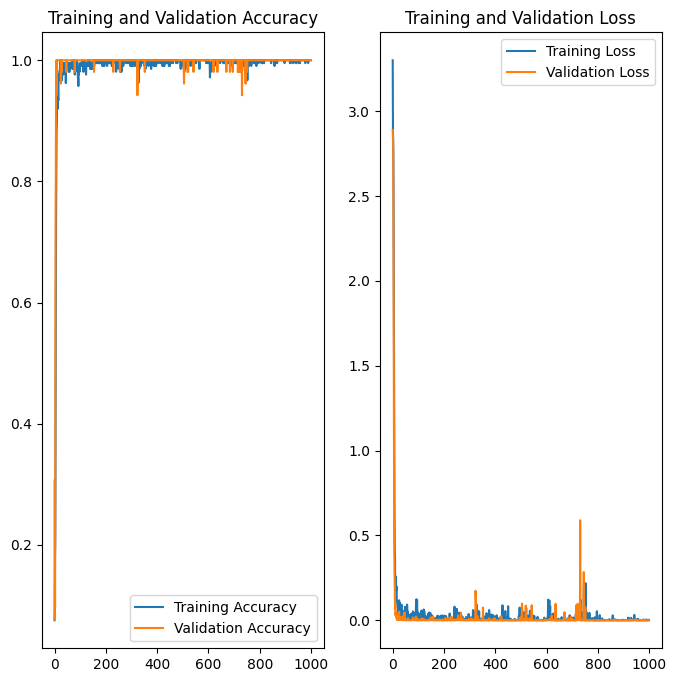

In [8]:
# acc ist die Variable, welche die Werte von der Trainingsgenauigkeit speichert.
# history.history ist wie eine Bibliothek, welche die Werte für Accuracy und Loss enthält, jeweils für Training und Validierung
# mit 'accuracy' werden dann die Werte Trainingsgenauigkeit aus der Bibliothek genommen
acc = history.history['accuracy']
# val_acc ist die Variable, welche die Werte von der Validierungsgenauigkeit speichert.
# wiederrum wird die Bibliothek histroy.history gebraucht, jetzt werden jedoch die Werte für die Validierungsgenauigkeit genommen durch 'val_accuracy'
val_acc = history.history['val_accuracy']

# loss ist die Variable, welche die Werte vom Trainingsloss speichert
# aus der Bibliothek history.history werden die Werte für den Trainingsloss genommen, durch den Schlüssel 'loss'
loss = history.history['loss']
# val_loss ist die Variable, welche die Werte vom Validierungsloss speichert
# aus der Bibliothek history.history werden nun die Werte für den Validierungsloss genommen, durch den Schlüssel 'val_loss'
val_loss = history.history['val_loss']

# epochs ist die Variable, welche am Anfang definiert wird, sie ist bei meinem Fall = 1000, also die Anzahl der Epochen
# range(epochs) ist eine Funktion, welche die die Sequenz von Zahlen zeigt beginnend mit 0 bis epochs-1, also bei mir [0, 1, 2, ..., 998, 999]
# Nun wird diese erzeugte Sequenz von Zahlen unter der Variablen epochs_range abgespeichert.
epochs_range = range(epochs)

# Nun wird durch die Matpltlib-Bibliothek die Diagramme erstellt
# Angefangen mit dem Diagrammfenster, welches die Grösse 8x8 Zoll hat, dies ist eine Matplotlib-Figur
plt.figure(figsize=(8, 8))

# plt.subplot() ist die Funktion von Matplotlip, welche gebraucht wir zum Erstellen und dann auch zum Auswählen von Subplots
# hier wird der Zeichenbereich in 1 Zeile und 2 Spalte aufgeteilt, wobei hier der erste Subplot ausgewählt, also unten das linke Diagramm
plt.subplot(1, 2, 1)
# Zeichnet die Werte von der Variablen acc, also die Trainingsgenauigkeit, von den Epochen epochs_range, als Linie in den aktuellen Subplot, 1
# label, fügt die Beschriftung Training Accuracy für die Linie hinzu
plt.plot(epochs_range, acc, label='Training Accuracy')
# Zeichnet die Werte von der Variablen val_acc, also die Validierungsgenauigkeit, von den Epochen epochs_range, als Linie in den aktuellen Subplot, 1
# label, fügt die Beschriftung Validation Accuracy für die Linie hinzu
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# mit plt.legend wird die Legende eingefügt mit den Beschriftungen für diesen Subplot, 'lower right' ist der Ort der Legende, also unten rechts
# unten rechts, da idealerweise die beiden Linien nach oben gehen sollten, also zu 1 hin, deshalb ist unten rechts Platz für die Legende.
plt.legend(loc='lower right')
# Damit wird dem aktuellen Subplot, 1, ein Titel gegeben, Training and Validation Accuracy
plt.title('Training and Validation Accuracy')

# plt.subplot() ist die Funktion von Matplotlip, welche gebraucht wir zum Erstellen und dann auch zum Auswählen von Subplots
# hier wird der Zeichenbereich in 1 Zeile und 2 Spalte aufgeteilt, wobei hier der zweite Subplot ausgewählt, also unten das rechte Diagramm
plt.subplot(1, 2, 2)
# Zeichnet die Werte von der Variablen loss, also den Trainingsloss, von den Epochen epochs_range, als Linie in den aktuellen Subplot, 2
# label, fügt die Beschriftung Training Loss für die Linie hinzu
plt.plot(epochs_range, loss, label='Training Loss')
# Zeichnet die Werte von der Variablen val_loss , also den Validationsloss, von den Epochen epochs_range, als Linie in den aktuellen Subplot, 2
# label, fügt die Beschriftung Validation Loss für die Linie hinzu
plt.plot(epochs_range, val_loss, label='Validation Loss')
# mit plt.legend wird die Legende eingefügt mit den Beschriftungen für diesen Subplot, 'upper right' ist der Ort der Legende, also oben rechts
# oben rechts, da idealerweise die beiden Linien nach unten gehen sollten, also zu 0 hin, deshalb ist oben rechts Platz für die Legende.
plt.legend(loc='upper right')
# Damit wird dem aktuellen Subplot, 2, ein Titel gegeben, Training and Validation Accuracy
plt.title('Training and Validation Loss')
# plt.show zeigt nun die beiden Diagramme an, durch das Öffnen eines seperatem Fensters wegen Matplotlib.
plt.show()
